In [1]:
import random
import string
import timeit
import os
import numpy as np

import cupy as cp # CUDA based implementation of numpy.ndarray (GPU)
from cupy.statistics.histogram import bincount

from collections import Counter
from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt

%matplotlib inline

In [35]:
class Searcher:
    """ Base class for all the searchers """

    def __init__(self, bowl):
        self.bowl = bowl

    def preprocess(self):
        pass
    
    def search(self):
        pass

class NaiveSearcher(Searcher):
    """ 
    Naive algorithm, iterates over the letters in the bowl until finding each letter in the message.
    The time complexity of this algorithm is of order O(n^2) 
    """

    def search(self, message):
        already_picked = []

        def findletter_naive(l):
            for idx,i in enumerate(self.bowl):
                if i == l and idx not in already_picked:
                    already_picked.append(idx)
                    return True
            else:
                return False

        return all(findletter_naive(i) for i in message)

class RandomSearcher(Searcher):
    """
    This is similar to the naive searcher but starting the search at random places in the bowl, if
    the bowl is big compared to the message and the letters are evenly distributed then the time complexity 
    should be of order O(n) because each letter will be found in a constant amount of time that depends 
    on the size of the alphabet.
    For bigger messages the performance will degrade to O(n^2)
    """
    
    def search(self, message):
        already_picked = {}

        def findletter_random(l):
            start = np.random.choice(len(self.bowl))
            for idx, i in enumerate(self.bowl[start: len(self.bowl)]):
                if i == l and idx+start not in already_picked:
                    already_picked[idx+start] = 1
                    return True
            for idx, i in enumerate(self.bowl[0: start]):
                if i == l and idx not in already_picked:
                    already_picked[idx] = 1
                    return True
            return False
        
        return all(findletter_random(i) for i in message)
    
class CounterSearcher(Searcher):
    """
    This algorithm starts by preprocessing the full bowl by counting how many letters of each kind the bowl
    contains. The counts are saved into a hashtable. This process is of complexity O(m). 
    After the preprocessing step each search is made in O(n) time since we have to access the hashtable 
    with the counts n times and each access to the hashtable is made in O(1) time.
    The very first search is then made in O(m + n) time.
    """
    
    def __init__(self, bowl):
        super(CounterSearcher, self).__init__(bowl)

    def preprocess(self):
        self.counts = Counter(self.bowl)
        
    def search(self, message):
        found = Counter()

        for letter in message:
            if letter in self.counts and self.counts[letter] > found[letter]: 
                found[letter] += 1
            else:
                return False

        return True

# This has to be declared as a global method otherwise there are some
# problems with the multiprocessing library
def countfn(x):
    return Counter(x)

class CounterSearcherParalell(CounterSearcher):
    """
    This is similar to the CounterSearcher class but the preprocessing step is executed in paralell.
    Since the counting problem is perfectly paralellizable we should get a linear speedup with the addition
    of processing cores. Two cores should count the letters in half the time than one.
    """
    
    def __init__(self, bowl, cores=cpu_count()):
        super(CounterSearcherParalell, self).__init__(bowl)
        print("Initialized process Pool with {} proccesses.".format(cores))
        self.pool = Pool(cores)
        self.cores = cores
        
    def preprocess(self):
        
        chunk_size = len(self.bowl) // self.cores

        def chunks(l, n):
            """Yield successive n-sized chunks from l.
            https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks"""
            for i in range(0, len(l), n):
                yield l[i:i + n]
        
        #map
        parts = self.pool.map(countfn, list(chunks(self.bowl, chunk_size)))
        self.counts = None
        
        #reduce
        for p in parts:
            if self.counts == None:
                self.counts = p
            else:
                self.counts += p

class CounterSearcherGPU(CounterSearcher):
    """ This is similar to the CounterSearcher class but the preprocessing is executed in a GPU. Since
    the counting problem is perfectly paralellizable this should be much faster.
    
    The calculation is done with the cupy library wich is an implementation of the numpy.ndarray class that 
    works in the GPU.
    """
    def preprocess(self):
        nums = np.fromstring(self.bowl, dtype=np.uint8)
        self.counts = bincount(cp.asarray(nums))
        self.counts = {chr(idx):int(val) for idx, val in enumerate(self.counts) if idx > 96 and idx < 123}        

class CounterSearcherOnline(Searcher):
    """
    This is an online version of the Counter algorithms. It works in the same way except that it builds 
    the counts incrementally. Experimentally its time complexity looks like its of order O(kn) with k 
    being some factor that depends on the size of the alphabet. 
    If the alphabet is big the probability of finding any given letter is smaller so we will spend a 
    little more time searching in the bowl instead of in the Counter.
,    """
    
    def search(self, message):
        
        counts = Counter()
        last_idx = 0
        found = 0
        
        for idx_message, i in enumerate(message):
            if i in counts and counts[i] > 0:
                found += 1
                counts[i] -= 1
                continue
            else:
                for idx_bowl, j in enumerate(self.bowl[last_idx:]):
                    if i == j:
                        found += 1
                        break
                    else:
                        counts[j] += 1
        
        return found == len(message)

In [22]:
def get_str(n):
    """ fast generation of random string """
    """ https://stackoverflow.com/questions/16308989/fastest-method-to-generate-big-random-string-with-lower-latin-letters """
    min_lc = ord(b'a')
    len_lc = 26
    ba = bytearray(os.urandom(n))
    for i, b in enumerate(ba):
        ba[i] = min_lc + b % len_lc # convert 0..255 to 97..122
    return ba.decode("utf-8")

def benchmark_bowls(searcher, range_, message_size=500, printfreq=100):
    """
    Executes a given searcher with increasing message sizes
    """
        
    message = get_str(500)
    
    times = []
    last = 0
    
    for i in range_:
        bowl = get_str(i)
        
        searcher.bowl = bowl
        start_time = timeit.default_timer()
        searcher.preprocess()
        elapsed = timeit.default_timer() - start_time
    
        searcher.search(message)
        # print logging message once every printfreq iterations
        if i // printfreq > last:
            last = i // printfreq
            print("{}(M={}) preprocessed bowl in {:f} seconds".format(
            searcher.__class__.__name__, len(bowl), elapsed))
    
        times.append(elapsed)
        
    return times
        
def benchmark_messages(searcher, bowl, range_, printfreq=100):
    """
    Executes a given searcher with increasing message sizes
    """
    
    times = []
    last = 0
    
    searcher.preprocess()
    
    for i in range_:
        
        message = get_str(i)
        
        start_time = timeit.default_timer()
        result = searcher.search(message)
        elapsed = timeit.default_timer() - start_time
        
        # print logging message once every printfreq iterations
        if i // printfreq > last:
            last = i // printfreq
            print("{}(N={}, M={}) returned {} in {:f} seconds".format(
            searcher.__class__.__name__, len(message), len(bowl), result, elapsed))
    
        times.append(elapsed)
        
    return times

In [43]:
bowl = get_str(1000000)

naive = NaiveSearcher(bowl)    
naive_times = benchmark_messages(naive, bowl, range(1,1000,10))

random = RandomSearcher(bowl)
random_times = benchmark_messages(random, bowl, range(1,1000,10))

counter = CounterSearcher(bowl)
counter_times = benchmark_messages(counter, bowl, range(1,1000,10))

counter_paralell = CounterSearcherParalell(bowl)
counter_paralell_times = benchmark_messages(counter_paralell, bowl, range(1,1000,10))

counter_gpu = CounterSearcherGPU(bowl)
counter_gpu_times = benchmark_messages(counter_gpu, bowl, range(1,1000,10))

counter_online = CounterSearcherOnline(bowl)
counter_online_times = benchmark_messages(counter_online, bowl, range(1, 1000, 10))

NaiveSearcher(N=101, M=1000000) returned True in 0.000956 seconds
NaiveSearcher(N=201, M=1000000) returned True in 0.003839 seconds
NaiveSearcher(N=301, M=1000000) returned True in 0.009067 seconds
NaiveSearcher(N=401, M=1000000) returned True in 0.018489 seconds
NaiveSearcher(N=501, M=1000000) returned True in 0.030565 seconds
NaiveSearcher(N=601, M=1000000) returned True in 0.048493 seconds
NaiveSearcher(N=701, M=1000000) returned True in 0.071711 seconds
NaiveSearcher(N=801, M=1000000) returned True in 0.101110 seconds
NaiveSearcher(N=901, M=1000000) returned True in 0.136947 seconds
RandomSearcher(N=101, M=1000000) returned True in 0.005253 seconds
RandomSearcher(N=201, M=1000000) returned True in 0.009895 seconds
RandomSearcher(N=301, M=1000000) returned True in 0.014310 seconds
RandomSearcher(N=401, M=1000000) returned True in 0.018990 seconds
RandomSearcher(N=501, M=1000000) returned True in 0.024046 seconds
RandomSearcher(N=601, M=1000000) returned True in 0.029137 seconds
Rand

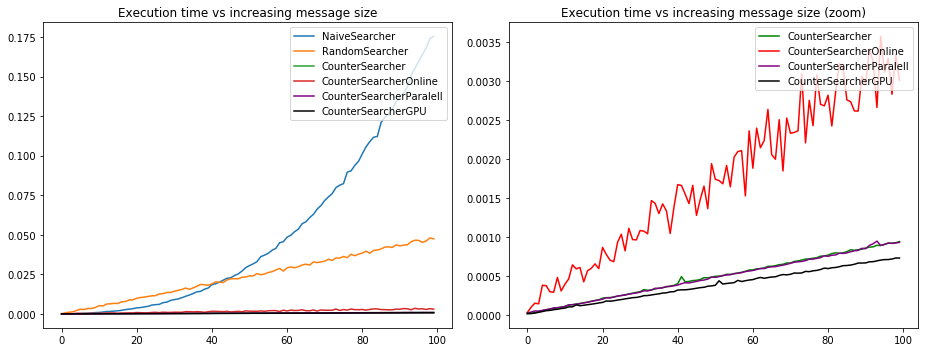

In [46]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.plot(naive_times, label="NaiveSearcher")
plt.plot(random_times, label="RandomSearcher")
plt.plot(counter_times, label="CounterSearcher")
plt.plot(counter_online_times, label="CounterSearcherOnline")
plt.plot(counter_paralell_times, label="CounterSearcherParalell", color='purple')
plt.plot(counter_gpu_times, label="CounterSearcherGPU", color='black')
plt.title('Execution time vs increasing message size')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(counter_times, label="CounterSearcher", color='green')
plt.plot(counter_online_times, label="CounterSearcherOnline", color='red')
plt.plot(counter_paralell_times, label="CounterSearcherParalell", color='purple')
plt.plot(counter_gpu_times, label="CounterSearcherGPU", color='black')
plt.legend(loc='upper right')
plt.title('Execution time vs increasing message size (zoom)')
plt.tight_layout()

In [48]:
dummy_bowl = get_str(100000)
counter_times = benchmark_bowls(CounterSearcher(dummy_bowl), 
                                range(10000,1000000,10000), 500, 100000)
counter_paralell_times = benchmark_bowls(CounterSearcherParalell(dummy_bowl), 
                                         range(10000,1000000,10000), 500, 100000)
counter_gpu_times = benchmark_bowls(CounterSearcherGPU(dummy_bowl), 
                                    range(10000,1000000,10000), 500, 100000)

CounterSearcher(M=100000) preprocessed bowl in 0.007445 seconds
CounterSearcher(M=200000) preprocessed bowl in 0.014833 seconds
CounterSearcher(M=300000) preprocessed bowl in 0.022332 seconds
CounterSearcher(M=400000) preprocessed bowl in 0.029665 seconds
CounterSearcher(M=500000) preprocessed bowl in 0.037380 seconds
CounterSearcher(M=600000) preprocessed bowl in 0.044687 seconds
CounterSearcher(M=700000) preprocessed bowl in 0.053058 seconds
CounterSearcher(M=800000) preprocessed bowl in 0.060785 seconds
CounterSearcher(M=900000) preprocessed bowl in 0.067797 seconds
Initialized process Pool with 4 proccesses.
CounterSearcherParalell(M=100000) preprocessed bowl in 0.006652 seconds
CounterSearcherParalell(M=200000) preprocessed bowl in 0.008634 seconds
CounterSearcherParalell(M=300000) preprocessed bowl in 0.012862 seconds
CounterSearcherParalell(M=400000) preprocessed bowl in 0.017121 seconds
CounterSearcherParalell(M=500000) preprocessed bowl in 0.021502 seconds
CounterSearcherParal

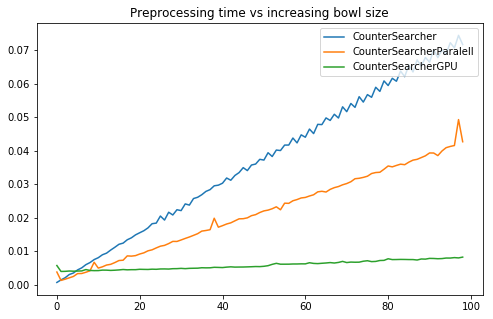

In [49]:
plt.figure(figsize=(8, 5))
plt.plot(counter_times, label="CounterSearcher")
plt.plot(counter_paralell_times, label="CounterSearcherParalell")
plt.plot(counter_gpu_times, label="CounterSearcherGPU")
plt.title('Preprocessing time vs increasing bowl size')
plt.legend(loc='upper right')

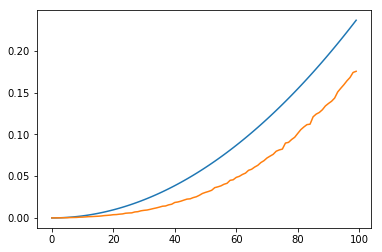

In [50]:
poly = np.polyfit([x for x, _ in enumerate(naive_times)], naive_times, 2)
poly[1] = 0
poly[2] = 0
plt.plot([np.polyval(poly, x) for x in range(100)])
plt.plot(naive_times)

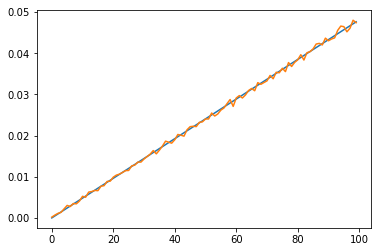

In [51]:
poly = np.polyfit([x for x, _ in enumerate(random_times)], random_times, 1)
poly[1] = 0
plt.plot([np.polyval(poly, x) for x in range(100)])
plt.plot(random_times)

Since the problem of counting the letters in the soup is perfectly paralell we would get a linear speedup on the number of processors used. We just have to partition de data and give each partition to each processor, then coalesce all the results. This can be done with a map-reduce operation pretty easily, here is an example that uses all the cores in the executing computer. 